In [207]:
import h5py
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import random
import torch
import torch.nn as nn

from PIL import Image
from torchvision import transforms
from sklearn.decomposition import PCA

rng = random.Random(42)

In [ ]:
TELLU_PATH = 'data/tellu.h5'
ORGAQUANT_PATH = 'data/orgaquant.h5'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Visualize datasets

In [209]:
def load_and_show_example(img_index=0, data_path=TELLU_PATH):
    with h5py.File(data_path, 'r') as hdf:
        group = hdf['train']
        img_names = list(group['images'].keys())
        
        target_name = img_names[img_index]
        print(f"Chargement de l'image : {target_name}")

        img = np.array(group['images'][target_name])
        labels = np.array(group['labels'][target_name])

    # Plots
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(img, cmap='gray')
    
    # Bounding Boxes
    for lbl in labels:
        # lbl = [class, x1, y1, x2, y2]
        if data_path == TELLU_PATH:
            x1, y1, x2, y2 = lbl[1], lbl[2], lbl[3], lbl[4]
        elif data_path == ORGAQUANT_PATH:
            x1, y1, x2, y2 = lbl[0], lbl[1], lbl[2], lbl[3]
        else:
            raise ValueError("Unknown data path")
        width = x2 - x1
        height = y2 - y1
        
        rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1, f"Org", color='white', bbox=dict(facecolor='red', alpha=0.5))

    plt.title(f"Visualization : {target_name}")
    plt.axis('off')
    plt.show()

In [210]:
for i in rng.sample(range(100), 3):
    print(f"Example {i}:")
    load_and_show_example(i, TELLU_PATH)

Example 81:
Chargement de l'image : Image171


Example 14:
Chargement de l'image : Image110


Example 3:
Chargement de l'image : Image100


Example 94:
Chargement de l'image : Subset_1_300x300_095


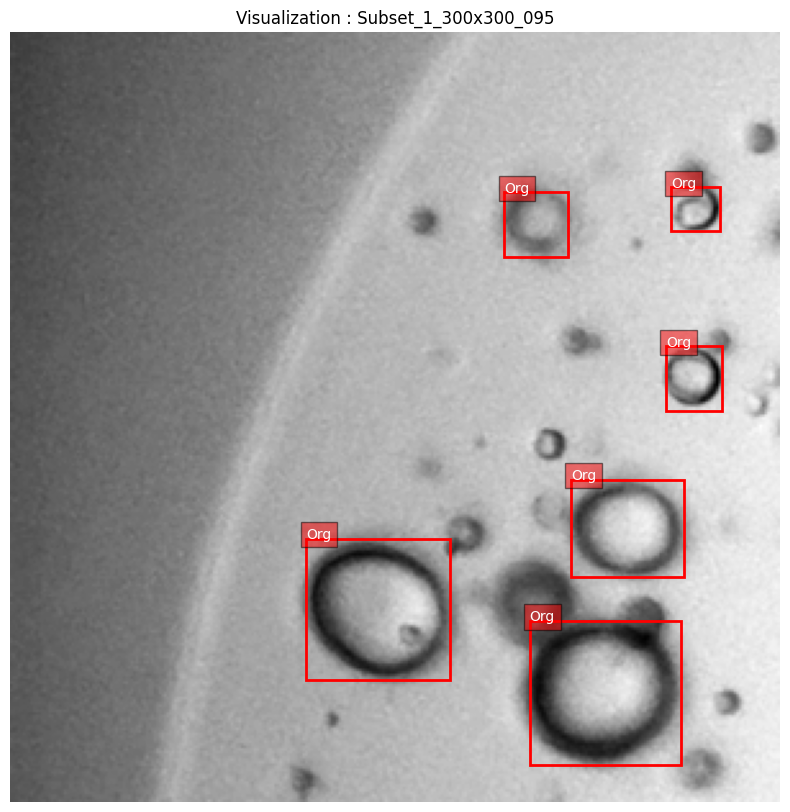

Example 35:
Chargement de l'image : Subset_1_300x300_036


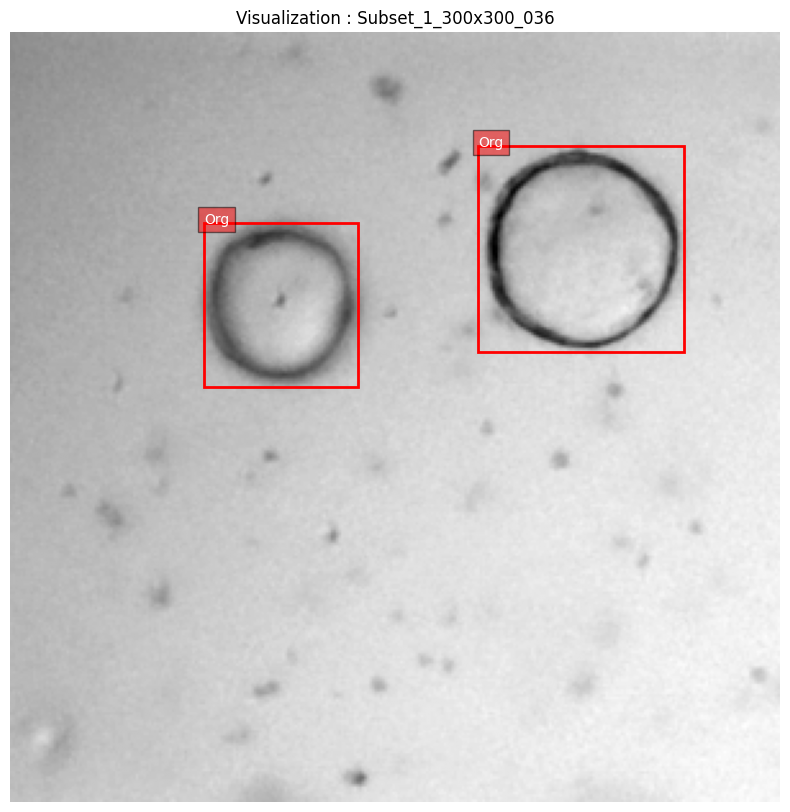

Example 31:
Chargement de l'image : Subset_1_300x300_032


In [211]:
for i in rng.sample(range(100), 3):
    print(f"Example {i}:")
    load_and_show_example(i, ORGAQUANT_PATH)

## Attention Maps

In [ ]:
def interpolate_pos_encoding(model, x, w, h):
    npatch = x.shape[1] - 1
    N = model.pos_embed.shape[1] - 1
    if npatch == N and w == h:
        return model.pos_embed

    class_pos_embed = model.pos_embed[:, 0]
    patch_pos_embed = model.pos_embed[:, 1:]
    dim = x.shape[-1]

    # get patch size (try common attribute names), fallback to 16
    patch_size = None
    pe = getattr(model, "patch_embed", None)
    if pe is not None:
        patch_size = getattr(pe, "patch_size", None) or getattr(pe, "patch_size", None)
        if isinstance(patch_size, (tuple, list)):
            patch_size = patch_size[0]
    if patch_size is None:
        patch_size = 14

    target_h = h // patch_size
    target_w = w // patch_size

    w0 = h0 = int(math.sqrt(N))
    patch_pos_embed = torch.nn.functional.interpolate(
        patch_pos_embed.reshape(1, w0, h0, dim).permute(0, 3, 1, 2),
        size=(target_w, target_h),
        mode='bicubic',
        align_corners=False,
    )
    patch_pos_embed = patch_pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
    return torch.cat((class_pos_embed.unsqueeze(0), patch_pos_embed), dim=1)

def get_attention_maps(model, transform, img_size, img_index=0, block_index=11, h5_path=TELLU_PATH, device=DEVICE):
    """Affiche les cartes d'attention pour une image et un bloc donnés."""
    if not os.path.exists(h5_path):
        print(f"Erreur : {h5_path} introuvable.")
        return

    with h5py.File(h5_path, 'r') as hdf:
        group = hdf['train']['images']
        img_names = list(group.keys())
        img_raw = np.array(group[img_names[img_index]])
    
    img_pil = Image.fromarray(img_raw).convert('RGB')
    img_tensor = transform(img_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        x = model.patch_embed(img_tensor)
        
        cls_token = model.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + interpolate_pos_encoding(model, x, img_size, img_size)
        
        for i in range(block_index):
            x = model.blocks[i](x)
        
        target_block = model.blocks[block_index]
        B, N, C = x.shape
        num_heads = target_block.attn.num_heads
        
        qkv = target_block.attn.qkv(x).reshape(B, N, 3, num_heads, C // num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        scale = target_block.attn.scale or (C // num_heads) ** -0.5
        attn = (q @ k.transpose(-2, -1)) * scale
        attn = attn.softmax(dim=-1)

    attentions = attn[0].cpu()
    nh = attentions.shape[0] 
    
    total_tokens = attentions.shape[-1]

    side = int(math.sqrt(total_tokens - 1))
    n_reg = total_tokens - 1 - (side * side) 
    
    start_idx = 1 + n_reg
    map_att = attentions[:, 0, start_idx:].reshape(nh, side, side)

    fig, axes = plt.subplots(1, nh + 1, figsize=(22, 5))
    axes[0].imshow(img_pil.resize((img_size, img_size)))
    axes[0].set_title(f"Original\n(Index {img_index}, Bloc {block_index})")
    axes[0].axis('off')
    
    for i in range(nh):
        axes[i+1].imshow(map_att[i], cmap='magma', interpolation='nearest')
        axes[i+1].set_title(f"Head {i}")
        axes[i+1].axis('off')
    
    plt.tight_layout()
    plt.show()

#### DINOv2 - ViT-S/14

In [ ]:
MODEL_URL = 'facebookresearch/dinov2'
MODEL = 'dinov2_vits14'

In [ ]:
# Img transformation to match model's expected input
img_size = 448 
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
model = torch.hub.load(MODEL_URL, MODEL).to(DEVICE)
model.eval()

Using cache found in C:\Users\perni/.cache\torch\hub\facebookresearch_dinov2_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affi

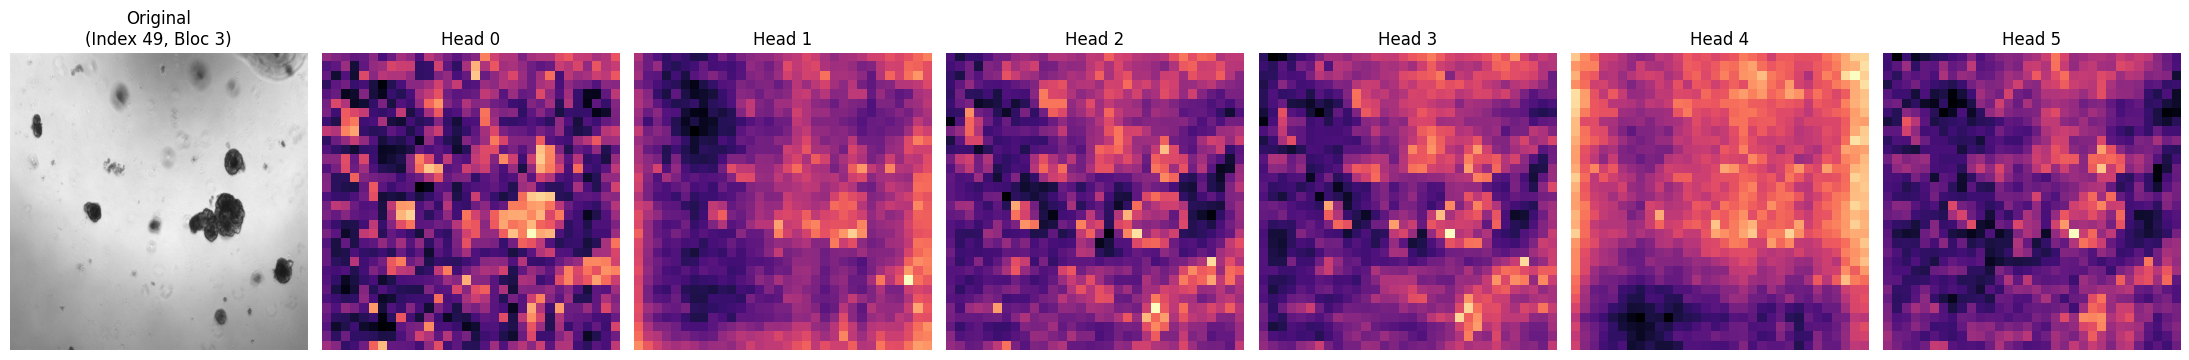

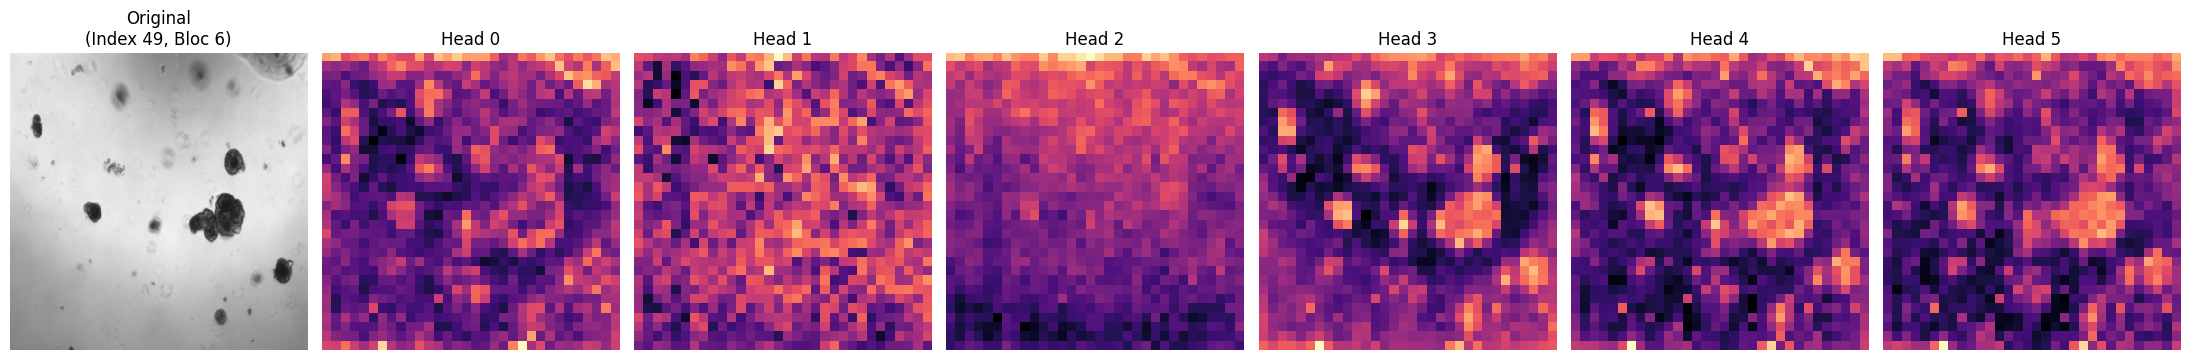

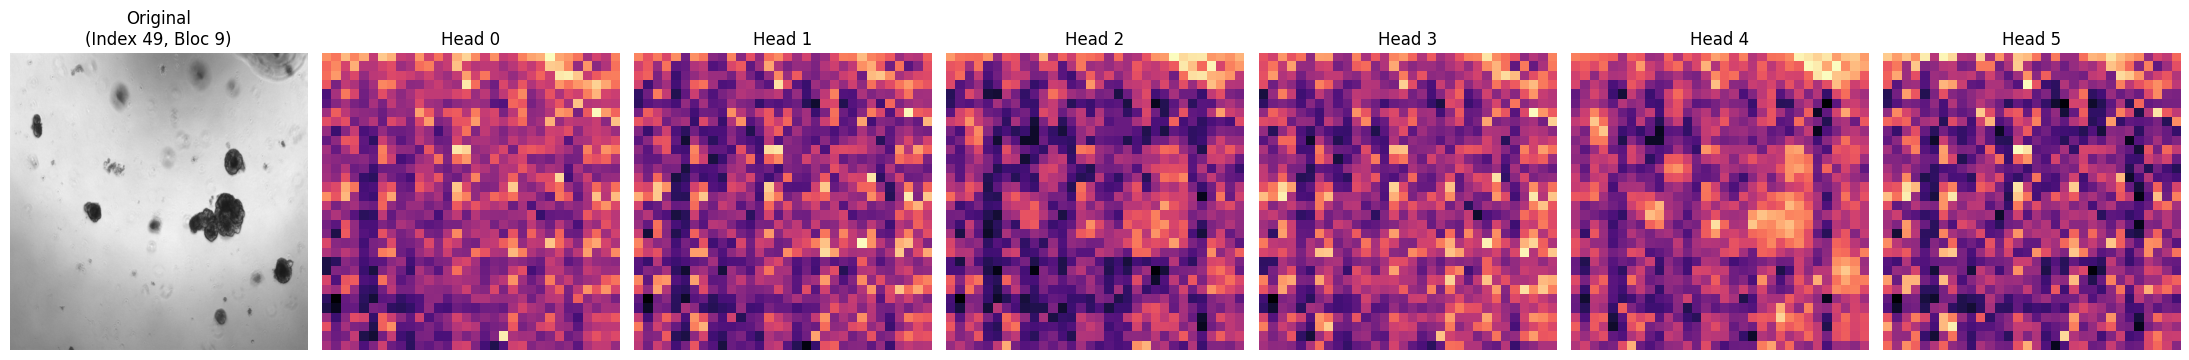

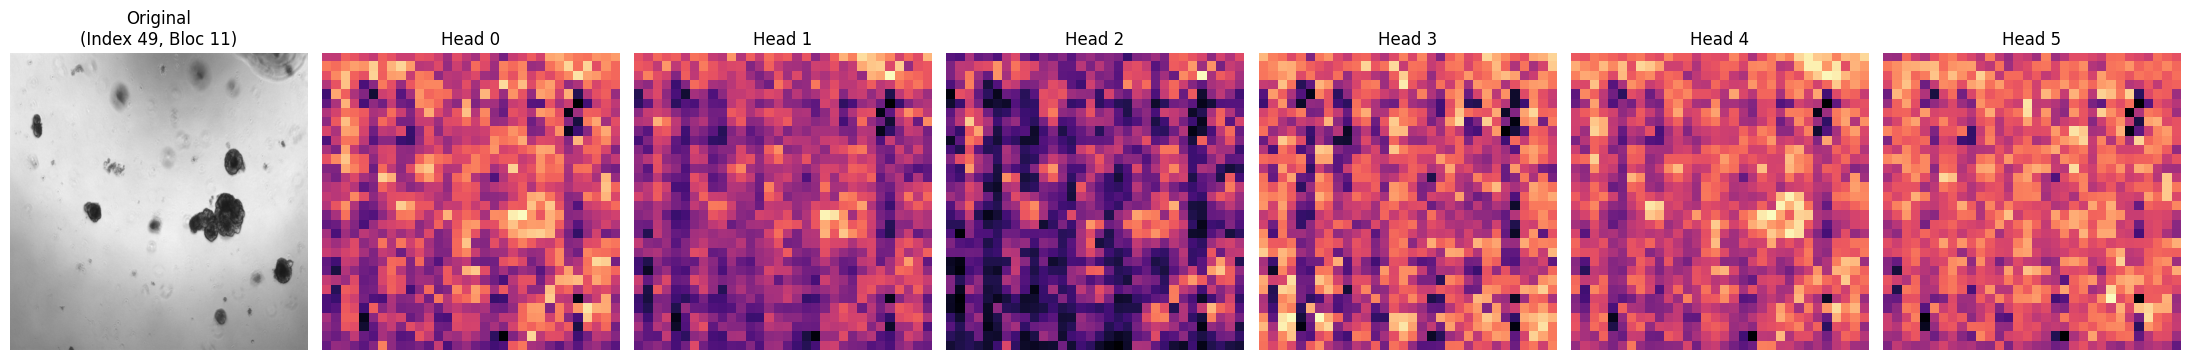

In [ ]:
for i in [0, 3, 6, 9, 11]:
    get_attention_maps(model, transform, img_size, img_index=49, block_index=i, h5_path=TELLU_PATH, device=DEVICE)

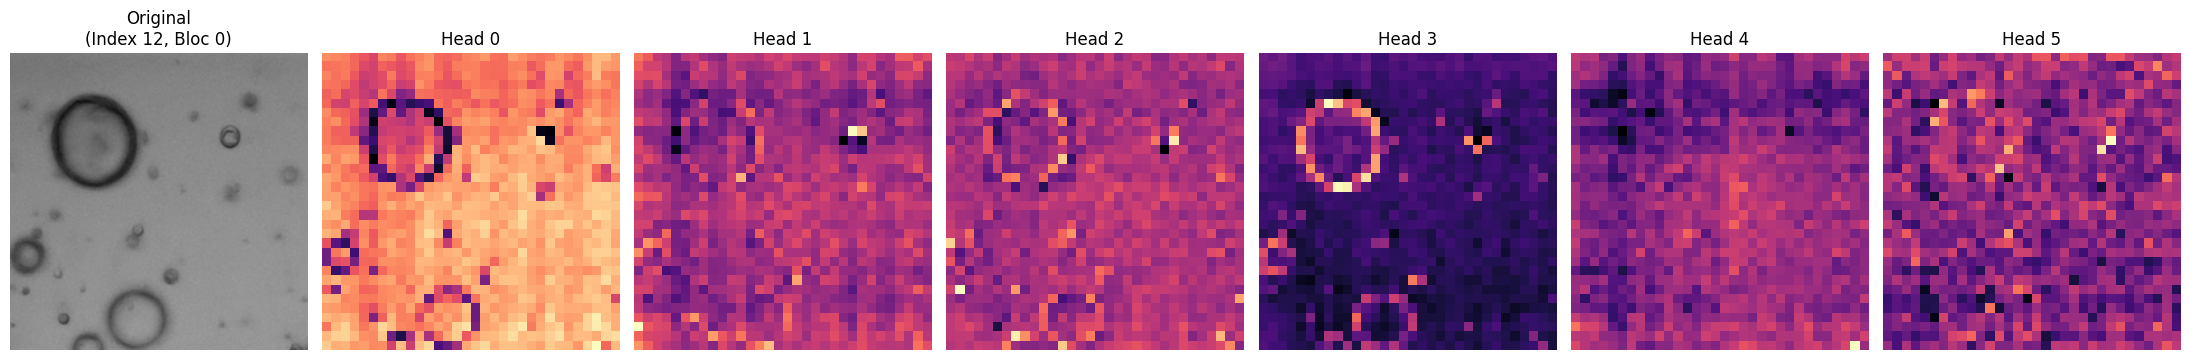

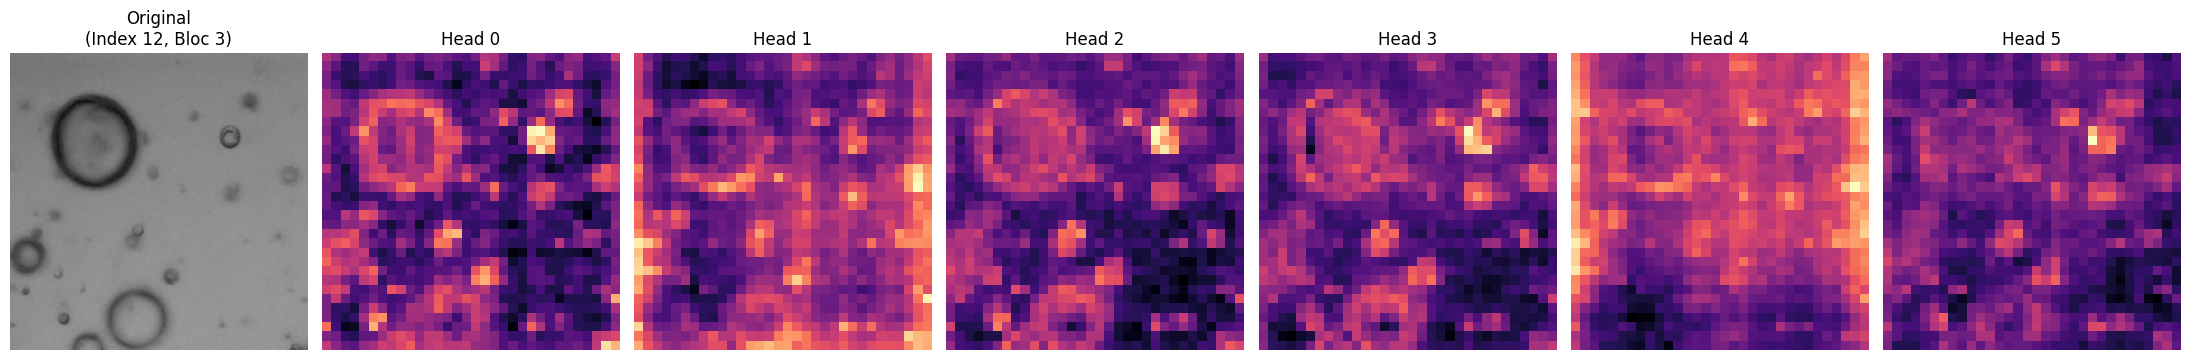

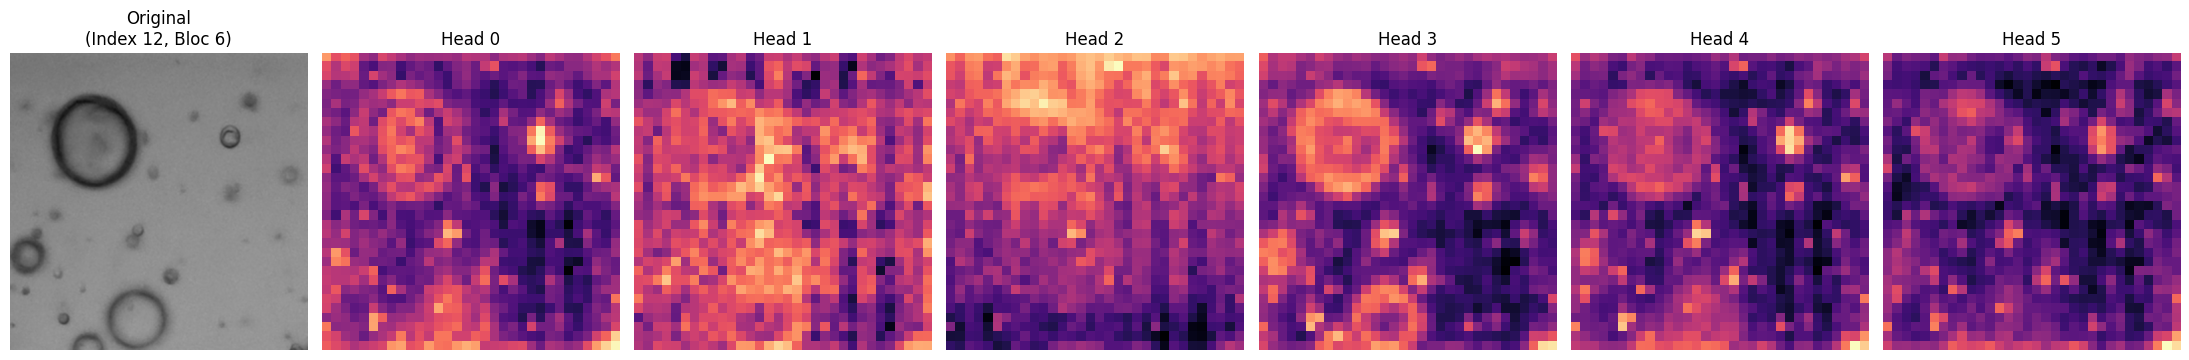

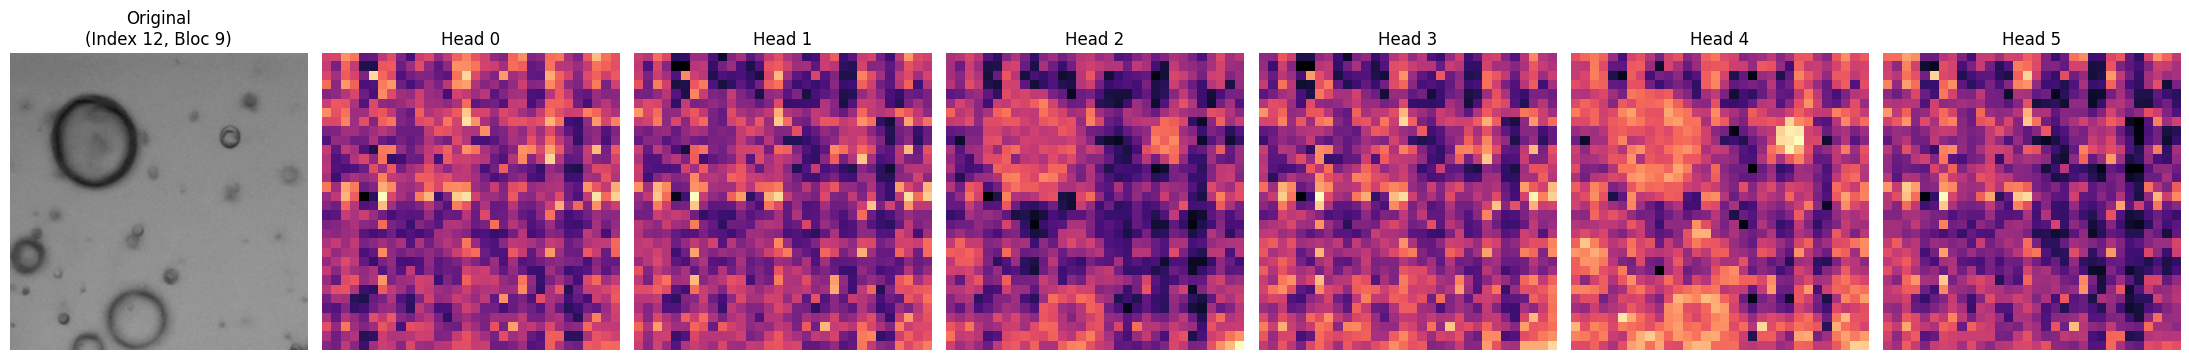

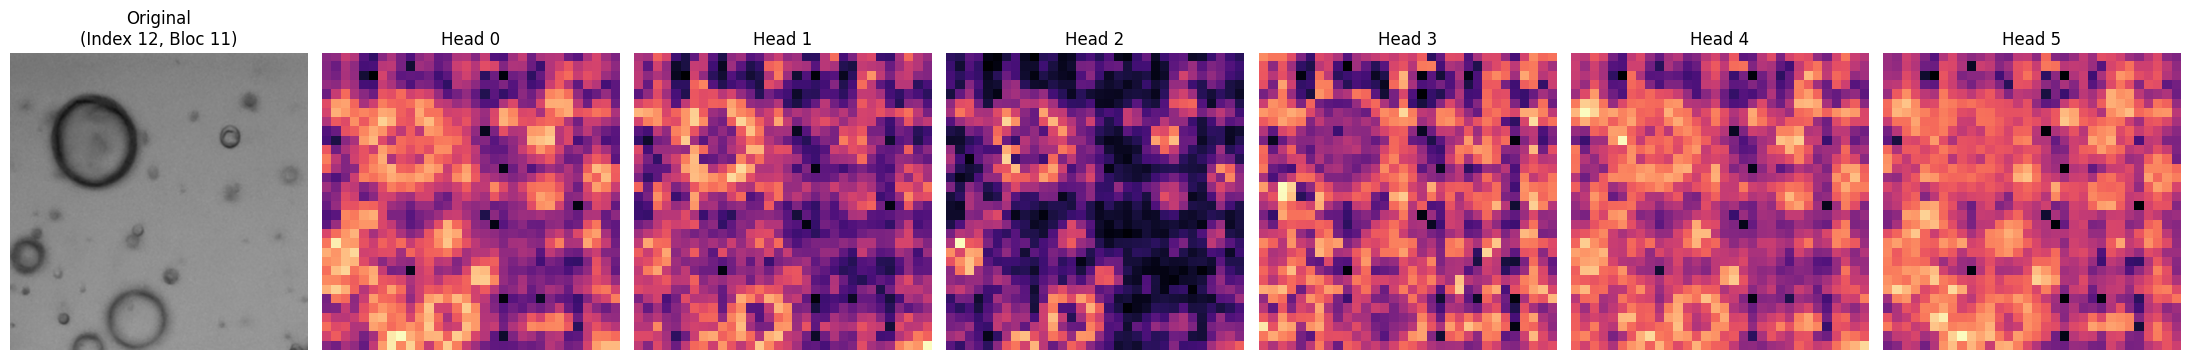

In [ ]:
for i in [0, 3, 6, 9, 11]:
    get_attention_maps(model, transform, img_size, img_index=12, block_index=i, h5_path=ORGAQUANT_PATH, device=DEVICE)

#### DINOv2 - ViT-B/14

In [ ]:
MODEL_URL = 'facebookresearch/dinov2'
MODEL = 'dinov2_vitb14'

In [114]:
# Img transformation to match model's expected input
img_size = 448 
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [115]:
model = torch.hub.load(MODEL_URL, MODEL).to(DEVICE)
model.eval()

Using cache found in C:\Users\perni/.cache\torch\hub\facebookresearch_dinov2_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affi

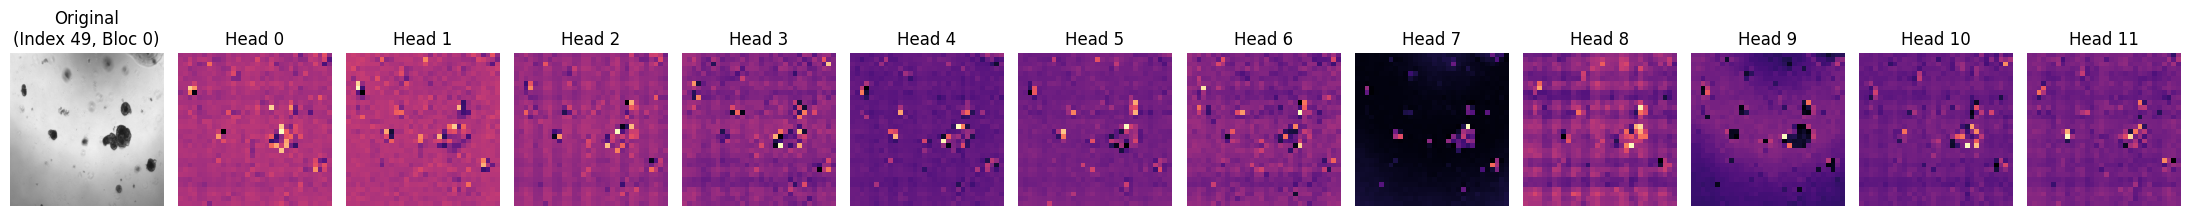

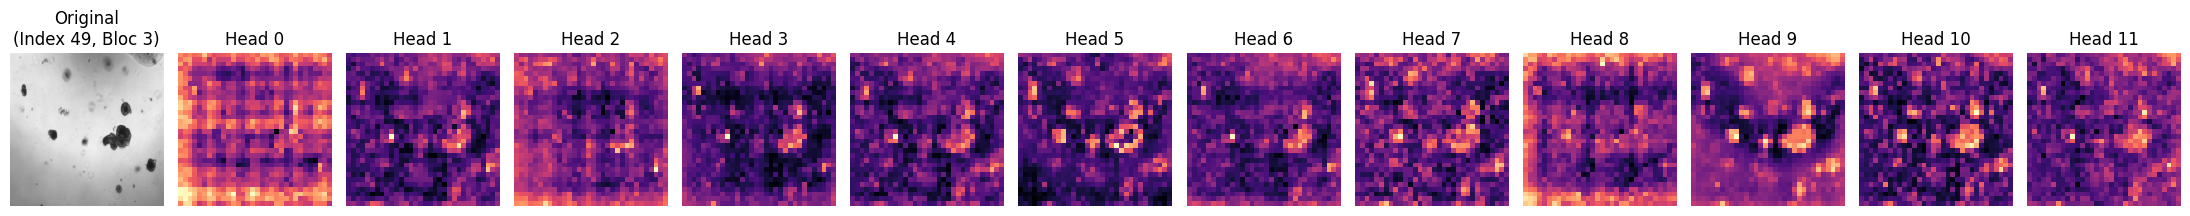

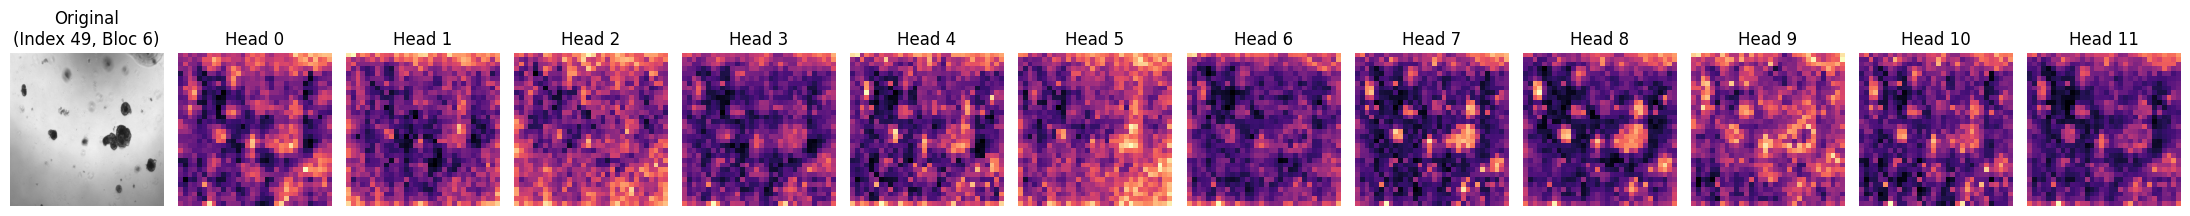

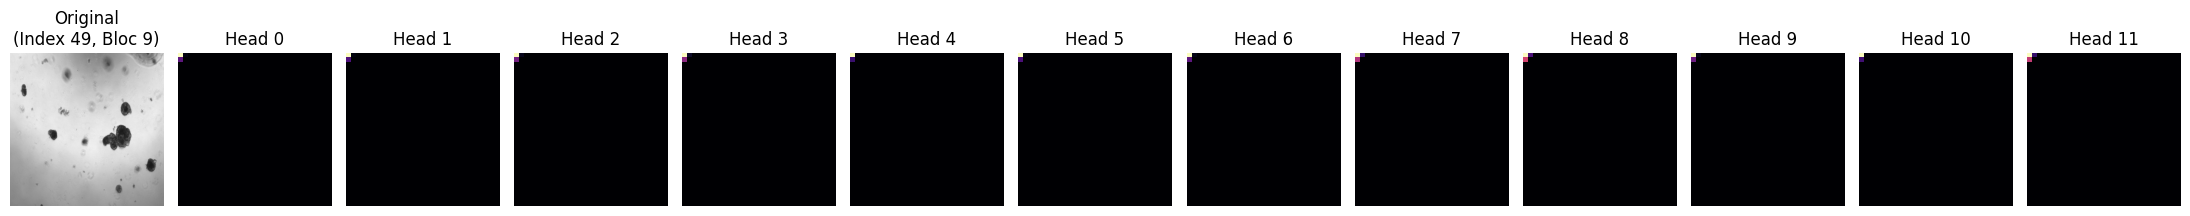

In [116]:
for i in [0, 3, 6, 9, 11]:
    get_attention_maps(model, transform, img_size, img_index=49, block_index=i, h5_path=TELLU_PATH, device=DEVICE)

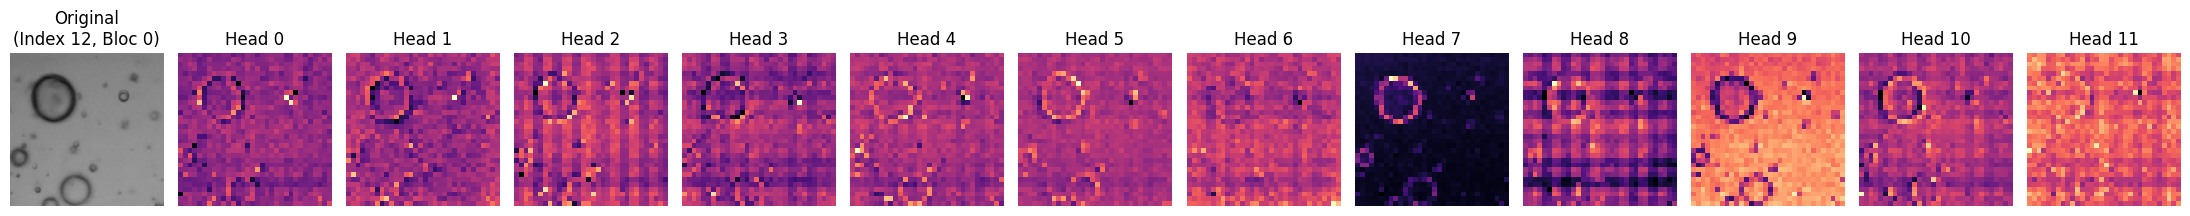

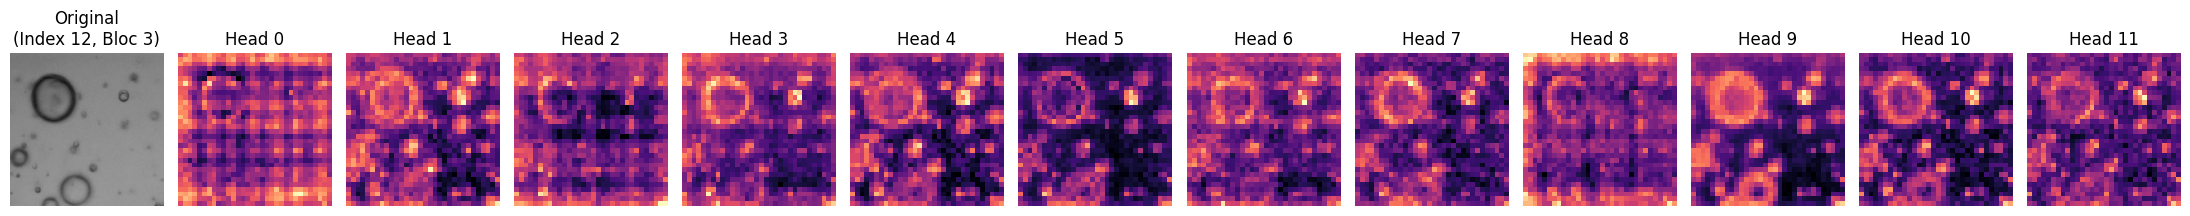

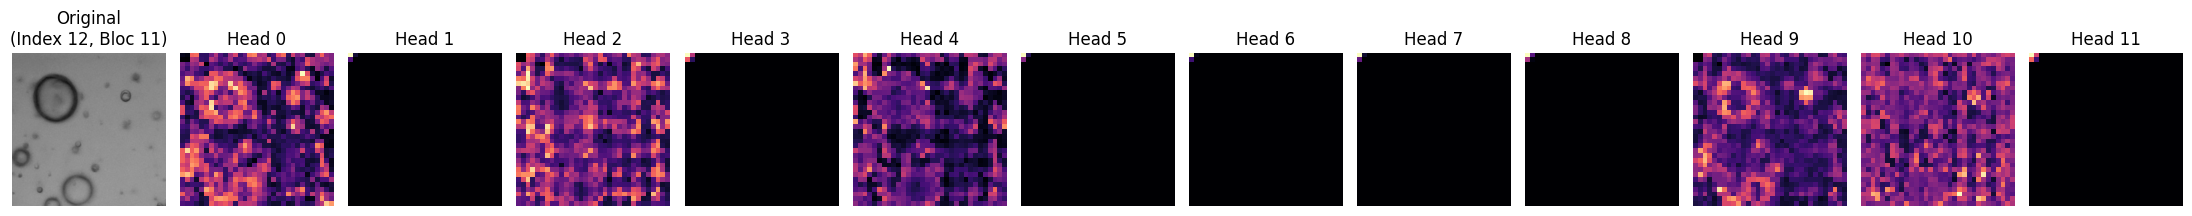

In [117]:
for i in [0, 3, 6, 9, 11]:
    get_attention_maps(model, transform, img_size, img_index=12, block_index=i, h5_path=ORGAQUANT_PATH, device=DEVICE)

## PCA at the Token-level

In [199]:
def interpolate_pos_encoding(model, x, w, h):
    """Gère l'adaptation des positions apprises à la nouvelle taille d'image."""
    npatch = x.shape[1] - 1
    N = model.pos_embed.shape[1] - 1
    if npatch == N and w == h:
        return model.pos_embed
    
    class_pos_embed = model.pos_embed[:, 0]
    patch_pos_embed = model.pos_embed[:, 1:]
    dim = x.shape[-1]
    
    w0 = h0 = int(math.sqrt(N))
    patch_pos_embed = torch.nn.functional.interpolate(
        patch_pos_embed.reshape(1, w0, h0, dim).permute(0, 3, 1, 2),
        size=(w // 14, h // 14),
        mode='bicubic',
        align_corners=False,
    )
    patch_pos_embed = patch_pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
    return torch.cat((class_pos_embed.unsqueeze(0), patch_pos_embed), dim=1)

def get_pca_maps(model, transform, img_size, img_index=0, block_index=11, bg_threshold=0.3, invert_pc=False, h5_path=TELLU_PATH, device=DEVICE):
    """
    Calcule et affiche les 3 premières composantes PCA des embeddings de patches avec visualisation RGB.
    Force le fond en noir via seuillage.
    
    Args:
        bg_threshold (float): Seuil pour le masque de fond (valeurs de PC1 < seuil = fond noir).
    """
    if not os.path.exists(h5_path):
        print(f"Erreur : {h5_path} introuvable.")
        return

    with h5py.File(h5_path, 'r') as hdf:
        group = hdf['train']['images']
        img_names = list(group.keys())
        img_raw = np.array(group[img_names[img_index]])
    
    img_pil = Image.fromarray(img_raw).convert('RGB')
    img_tensor = transform(img_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        x = model.patch_embed(img_tensor)
        
        cls_token = model.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + interpolate_pos_encoding(model, x, img_size, img_size)
        
        for i in range(block_index + 1):
            x = model.blocks[i](x)
    
    # 1. Extraire les embeddings des patches sans CLS token
    patch_embeddings = x[0, 1:].cpu().numpy() # (num_patches, dim)
    
    # 2. PCA
    pca = PCA(n_components=3)
    pca_features = pca.fit_transform(patch_embeddings)  # (num_patches, 3)
    
    # 3. Grille de patches
    total_patches = pca_features.shape[0]
    grid_size = int(np.sqrt(total_patches))
    n_reg = total_patches - (grid_size * grid_size)
    
    if n_reg > 0:
        pca_features = pca_features[n_reg:]
        grid_size = int(np.sqrt(pca_features.shape[0]))
    
    # 4. Normalisation et Astuce du Fond Noir par composante
    rgb_channels = []
    
    pc1 = pca_features[:, 0]
    pc1_min, pc1_max = pc1.min(), pc1.max()
    pc1_norm = (pc1 - pc1_min) / (pc1_max - pc1_min) if pc1_max > pc1_min else np.zeros_like(pc1)
    # si moyenne > 0.5, le fond est clair
    if invert_pc:
        pc1_norm = 1.0 - pc1_norm
    
    rgb_channels.append(pc1_norm)
    
    for i in range(1, 3):
        pc = pca_features[:, i]
        pc_min, pc_max = pc.min(), pc.max()
        pc_norm = (pc - pc_min) / (pc_max - pc_min) if pc_max > pc_min else np.zeros_like(pc)
        if invert_pc:
            pc_norm = 1.0 - pc_norm
        rgb_channels.append(pc_norm)
    
    # 5. Création de l'image RGB
    rgb_flat = np.stack(rgb_channels, axis=-1) # (num_patches, 3)
    
    # Masque de fond
    mask = pc1_norm > bg_threshold
    rgb_flat = rgb_flat * mask[:, np.newaxis]
    
    # 6. Reshape en grille spatiale
    pca_maps = rgb_flat.reshape(grid_size, grid_size, 3) # (H, W, 3)
    
    pc1_map = pc1_norm.reshape(grid_size, grid_size)
    pc2_map = rgb_channels[1].reshape(grid_size, grid_size)
    pc3_map = rgb_channels[2].reshape(grid_size, grid_size)
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))
    
    # Image originale
    axes[0].imshow(img_pil.resize((img_size, img_size)))
    axes[0].set_title(f"Original\n(Index {img_index}, Bloc {block_index})")
    axes[0].axis('off')
    
    # Composantes individuelles en niveaux de gris
    axes[1].imshow(pc1_map, cmap='gray', interpolation='nearest', vmin=0, vmax=1)
    axes[1].set_title(f"PC1 (R)\n({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
    axes[1].axis('off')
    
    axes[2].imshow(pc2_map, cmap='gray', interpolation='nearest', vmin=0, vmax=1)
    axes[2].set_title(f"PC2 (G)\n({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
    axes[2].axis('off')
    
    axes[3].imshow(pc3_map, cmap='gray', interpolation='nearest', vmin=0, vmax=1)
    axes[3].set_title(f"PC3 (B)\n({pca.explained_variance_ratio_[2]*100:.1f}% variance)")
    axes[3].axis('off')
    
    # Visualisation RGB
    axes[4].imshow(pca_maps, interpolation='nearest')
    axes[4].set_title(f"PCA RGB\n(Total: {pca.explained_variance_ratio_.sum()*100:.1f}%)")
    axes[4].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Total explained variance: {pca.explained_variance_ratio_.sum()*100:.2f}%")
    print(f"Foreground pixels: {mask.sum()} / {mask.size} ({100*mask.sum()/mask.size:.1f}%)")

#### DINOv2 - ViT-S/14

In [ ]:
MODEL_URL = 'facebookresearch/dinov2'
MODEL = 'dinov2_vits14'

In [187]:
# Img transformation to match model's expected input
img_size = 448 
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [188]:
model = torch.hub.load(MODEL_URL, MODEL).to(DEVICE)
model.eval()

Using cache found in C:\Users\perni/.cache\torch\hub\facebookresearch_dinov2_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affi

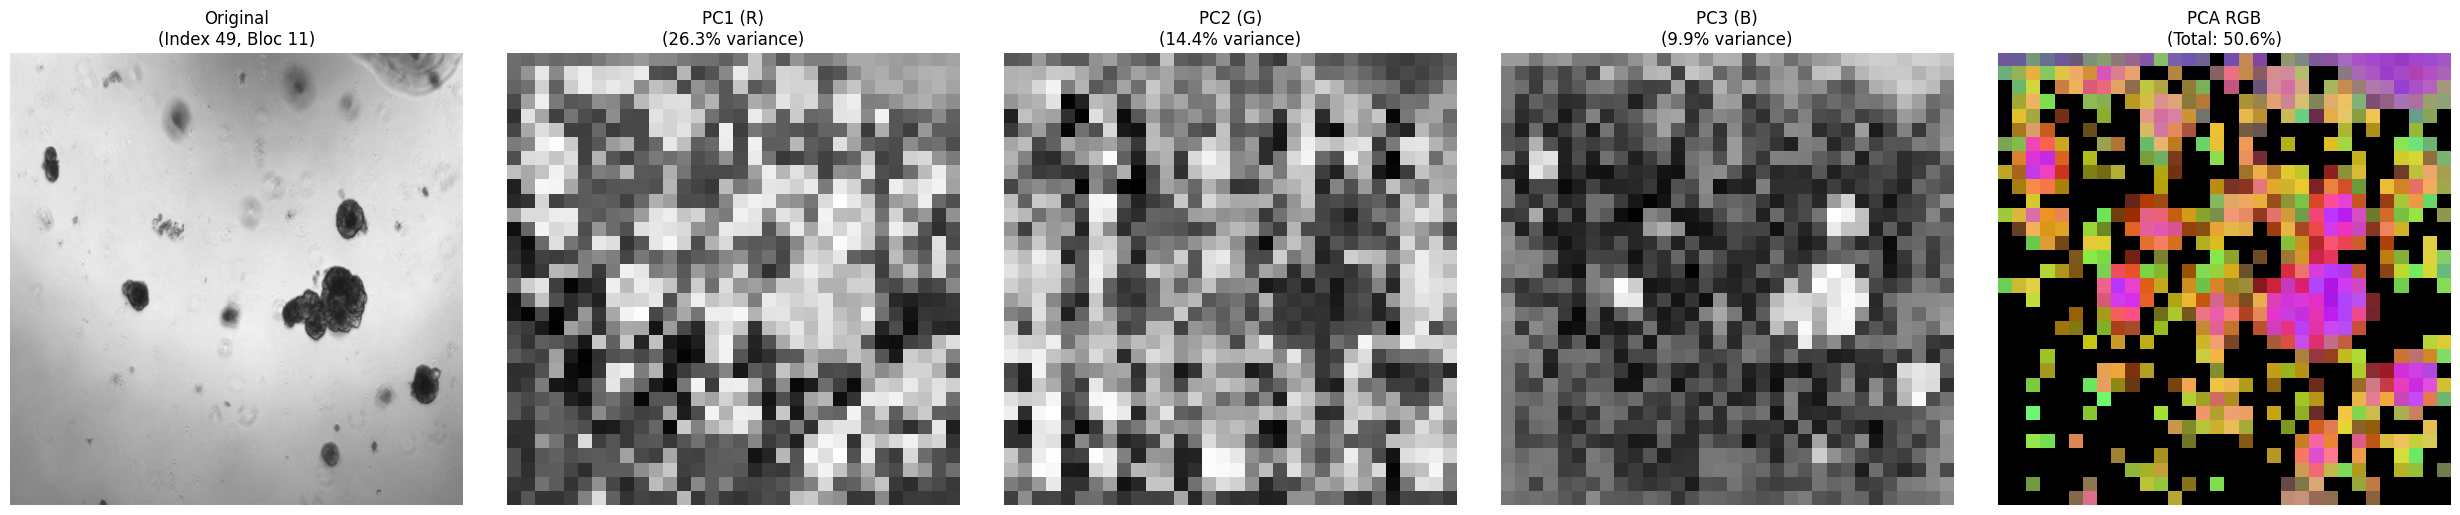

Total explained variance: 50.61%
Foreground pixels: 586 / 1024 (57.2%)


In [200]:
get_pca_maps(model, transform, img_size, img_index=49, block_index=11, h5_path=TELLU_PATH, bg_threshold=0.4)

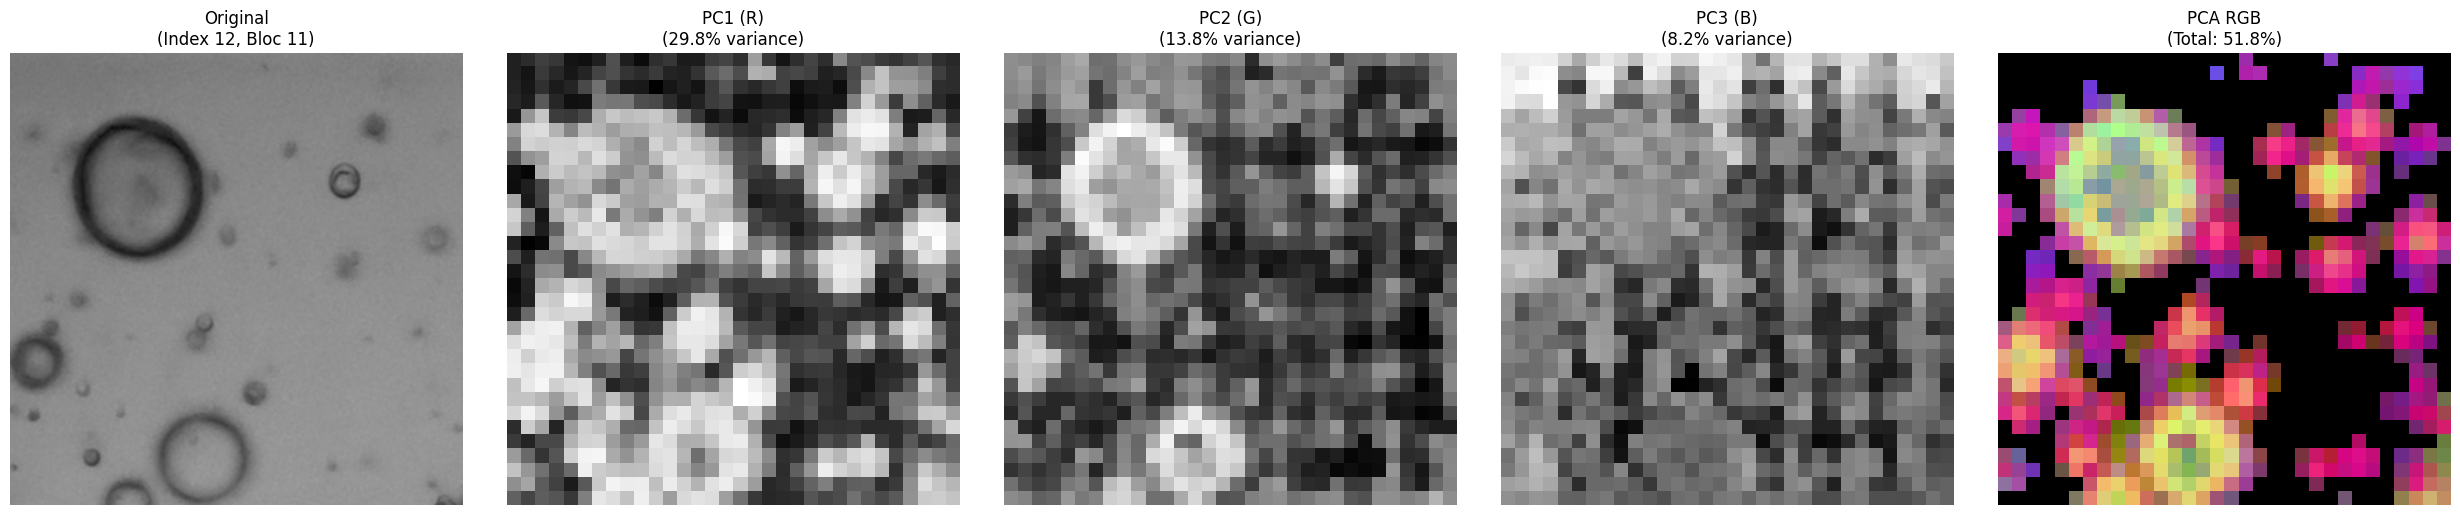

Total explained variance: 51.77%
Foreground pixels: 598 / 1024 (58.4%)


In [201]:
get_pca_maps(model, transform, img_size, img_index=12, block_index=11, h5_path=ORGAQUANT_PATH, bg_threshold=0.4)

#### DINOv2 - ViT-B/14

In [ ]:
MODEL_URL = 'facebookresearch/dinov2'
MODEL = 'dinov2_vitb14'

In [213]:
# Img transformation to match model's expected input
img_size = 448 
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [214]:
model = torch.hub.load(MODEL_URL, MODEL).to(DEVICE)
model.eval()

Using cache found in C:\Users\perni/.cache\torch\hub\facebookresearch_dinov2_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affi

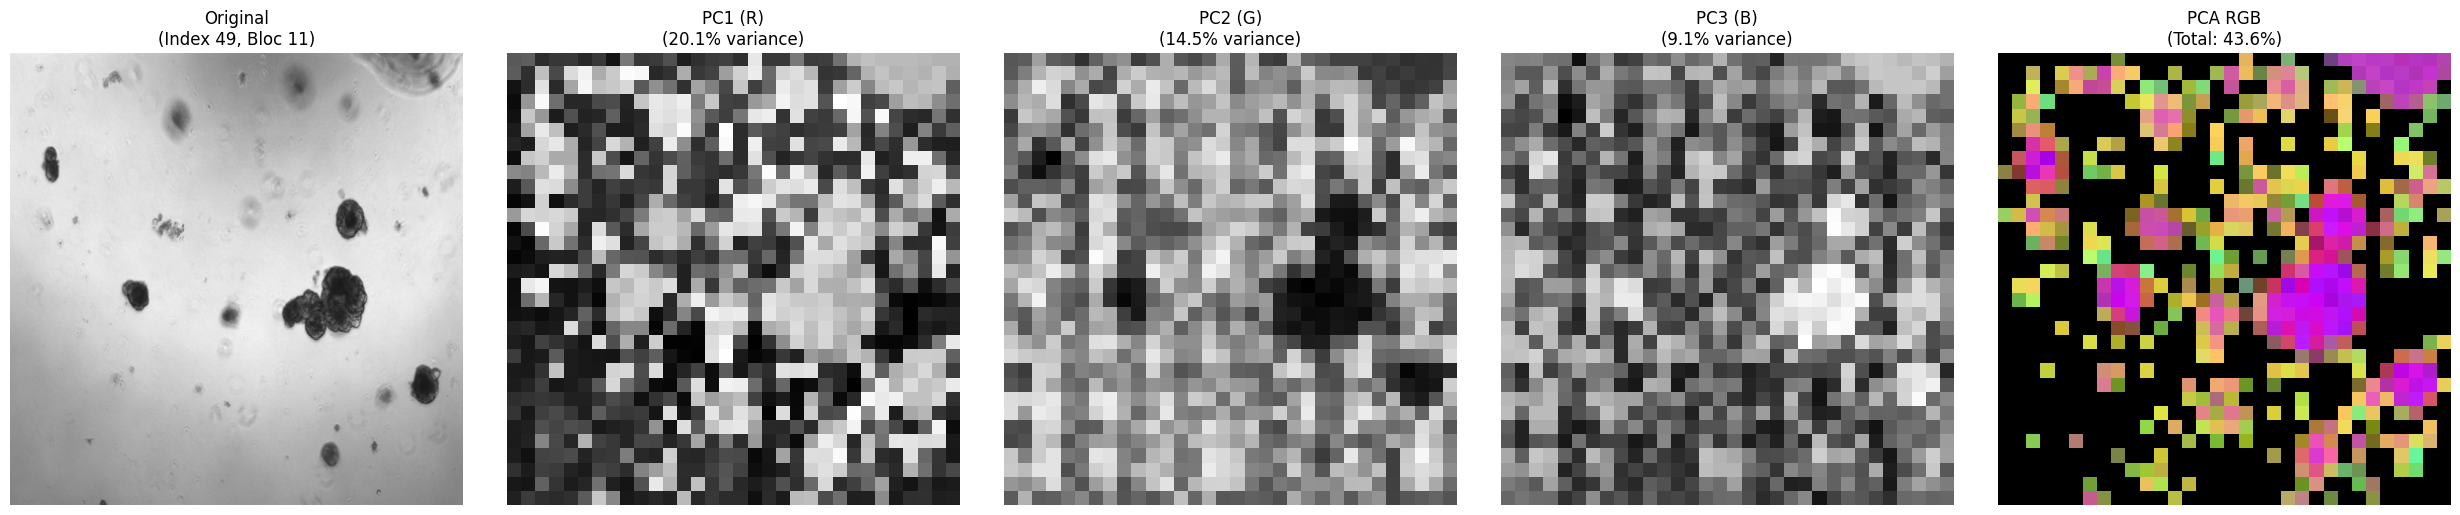

Total explained variance: 43.63%
Foreground pixels: 469 / 1024 (45.8%)


In [205]:
get_pca_maps(model, transform, img_size, img_index=49, block_index=11, h5_path=TELLU_PATH, bg_threshold=0.4, invert_pc=True)

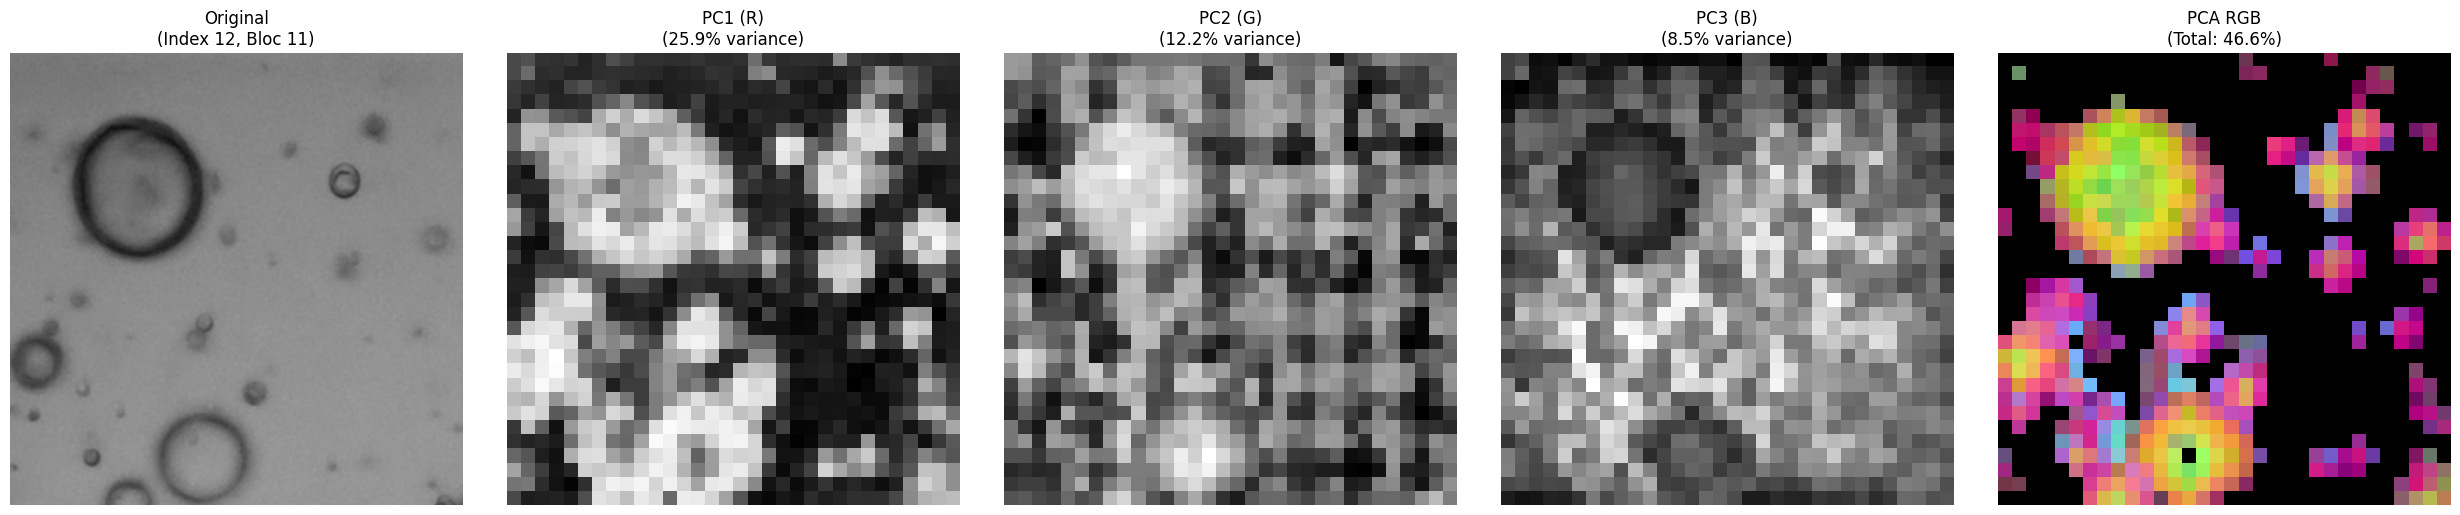

Total explained variance: 46.62%
Foreground pixels: 475 / 1024 (46.4%)


In [206]:
get_pca_maps(model, transform, img_size, img_index=12, block_index=11, h5_path=ORGAQUANT_PATH, bg_threshold=0.4)